In [1]:
import numpy as np
import nibabel as nib
from nilearn import datasets
import os.path as op
import os
import pandas as pd

bids_folder = '/mnt_03/ds-dnumrisk' 
target_dir = op.join(bids_folder,'derivatives','gradients')

In [4]:
#from utils import get_glasser_parcels
from brainspace.utils.parcellation import map_to_labels
space = 'fsaverage5'
base_folder='/mnt_03/diverse_neuralData/atlases_parcellations'
atlas_left = nib.load(op.join(base_folder,f'lh_space-{space}.HCPMMP1.gii')).agg_data()

mask_half = ~np.isin(atlas_left,0)
labeling_half = atlas_left


gms = np.load(op.join(target_dir,f'gradients_av_glasserParcel_group-All.npy'),).T
gms_split = np.split(gms,2,axis=1)
gms_dif = gms_split[0] - gms_split[1]
print(np.shape(gms_dif))

grad_dif = [None] * 10
for i, g in enumerate(gms_dif): # unaligned
    grad_dif[i] = map_to_labels(g, labeling_half, mask=mask_half, fill=np.nan)



(10, 180)


In [5]:
# better to do it in parcel space and then convert, this here does not work 
from utils import get_glasser_parcels

mask, labeling = get_glasser_parcels(space='fsaverage5')
grad = [None] * 10
for i, g in enumerate(gms): # unaligned
    grad[i] = map_to_labels(g, labeling, mask=mask, fill=np.nan)

gm = np.split(grad[i],2) # for i, hemi in enumerate(['L', 'R']): --> left first
gm_r = gm[1]# right
gm_dif = gm[0] - gm[1]

# plotting gm_dif has two median wall reagions with Nans or somehing.... 
# dont completelty understand yet how vertices  of L/R correspond to each other in surface space
#np.argwhere(np.isnan(np.flip(gm_r), )) # testing this...


In [6]:
from  nilearn.datasets import fetch_surf_fsaverage
import nilearn.plotting as nplt
import matplotlib.pyplot as plt

fsaverage = fetch_surf_fsaverage('fsaverage5') 

In [26]:
i = 1
grad_map = grad_dif[i]



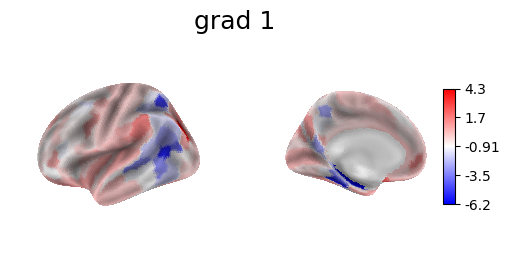

In [24]:
cmap = 'bwr'
figure, axes = plt.subplots(nrows=1, ncols=2, subplot_kw=dict(projection='3d'),figsize=(6,3))

nplt.plot_surf(surf_mesh= fsaverage.infl_left, surf_map= grad_map, # infl_right # pial_right
            view= 'lateral',cmap=cmap, colorbar=False, title=f'grad {i+1}',
            bg_map=fsaverage.sulc_left, bg_on_data=True,darkness=0.7, axes=axes[0]) 
nplt.plot_surf(surf_mesh= fsaverage.infl_left, surf_map= grad_map, # infl_right # pial_right
            view= 'medial',cmap=cmap, colorbar=True, title=f'grad {i+1}',
            bg_map=fsaverage.sulc_left, bg_on_data=True,darkness=0.7, axes=axes[1]) 
plt.show()


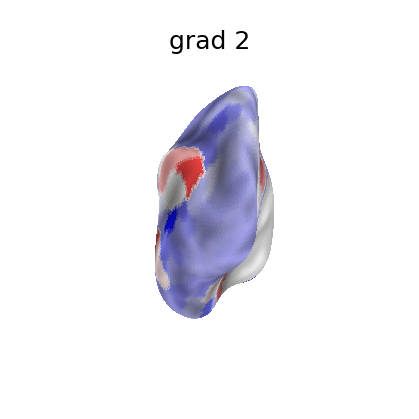

In [27]:
nplt.plot_surf(surf_mesh= fsaverage.infl_left, surf_map= grad_map, # infl_right # pial_right
            view= 'posterior',cmap=cmap, colorbar=False, title=f'grad {i+1}',
            bg_map=fsaverage.sulc_left, bg_on_data=True,darkness=0.7) 
plt.show()

In [ ]:
subList = [f[4:6] for f in os.listdir(bids_folder) if f[0:4] == 'sub-' and len(f) == 6]

N_subs = 66
grad_difs = [None] * len(subList)

for i_sub, sub in enumerate(subList): 
    source_folder_gm = op.join(bids_folder,'derivatives','gradients',f'sub-{sub}')
    gm_file = op.join(source_folder_gm,f'sub-{sub}_g-aligned_glasserParcel.npy')

    gms = np.load(gm_file).T
    gms_split = np.split(gms,2,axis=1)
    gms_dif = gms_split[0] - gms_split[1]

    grad_dif = [None] * 10
    for i, g in enumerate(gms_dif): # unaligned
        grad_dif[i] = map_to_labels(g, labeling_half, mask=mask_half, fill=np.nan)
    
    grad_difs[i_sub] = grad_dif

print(np.shape(grad_difs))


(66, 10, 10242)


In [62]:
# do statitics on parcel level, mappingg bakc to surface as a very last step!

subList = [f[4:6] for f in os.listdir(bids_folder) if f[0:4] == 'sub-' and len(f) == 6]

N_subs = 66
grad_difs = [None] * len(subList)

for i_sub, sub in enumerate(subList): 
    source_folder_gm = op.join(bids_folder,'derivatives','gradients',f'sub-{sub}')
    gm_file = op.join(source_folder_gm,f'sub-{sub}_g-aligned_glasserParcel.npy')

    gms = np.load(gm_file).T
    gms_split = np.split(gms,2,axis=1)
    gms_dif = gms_split[0] - gms_split[1]


    grad_difs[i_sub] = gms_dif

print(np.shape(grad_difs))

(66, 10, 180)


In [67]:
data = np.array(grad_difs)
n_parcels = np.shape(grad_difs)[2] # 180
reshaped_data = data.reshape(66 * 10, n_parcels)

sub_array= np.array([int(i) for i in subList]) 
sub_indices = np.repeat(sub_array, 10)   # Repeats each subject index 10 times
n_gradient_indices = np.tile((np.arange(10)+1), 66)  # Tiles gradient index for each subject

multi_index = pd.MultiIndex.from_arrays([sub_indices, n_gradient_indices], names=["subject", "n_gradient"])

df = pd.DataFrame(reshaped_data, index=multi_index)

# Set column names (optional)
df.columns = [f"parcel_{i+1}" for i in range(n_parcels)]

In [68]:
# add group info
df_participants = pd.read_csv(op.join(bids_folder, 'add_tables','subjects_recruit_scan_scanned-final.csv'), header=0) #, index_col=0
group_list = df_participants.loc[:,['subject ID','group']].rename(mapper={'subject ID': 'subject'},axis=1).dropna().astype({'subject': int, 'group': int}).set_index('subject')
group_list = group_list#.reset_index()

df = df.reset_index().merge(group_list, on='subject').set_index(['subject','n_gradient','group'])

In [69]:
df.head()

parcel_1  parcel_2  parcel_3  parcel_4  parcel_5  \
subject n_gradient group                                                     
21      1          0      0.093503  3.806749 -2.496132 -0.768033  0.121909   
        2          0      0.011309  2.347331  1.898655  0.081484  0.114635   
        3          0      0.105004  0.220550 -0.936844  0.089426  0.148870   
        4          0      0.064929 -1.154675 -0.518521  0.054749  0.011578   
        5          0      0.187060  0.613536  0.586014  0.173725 -0.047430   

                          parcel_6  parcel_7  parcel_8  parcel_9  parcel_10  \
subject n_gradient group                                                      
21      1          0     -0.579942 -1.292712  0.586383  0.996456   3.551495   
        2          0      0.007416  0.182246  0.267330  0.255918   0.397689   
        3          0      0.100549  0.304146  0.992795  1.832967   1.539603   
        4          0      0.089729  0.231117 -0.269901 -0.525914   0.318661   
        5          0     -0.136286 -0.118107  0.048810 -0.205636  -0.499100   

                          ...  parcel_171  parcel_172  parcel_173  parcel_174  \
subject n_gradient group  ...                                                   
21      1          0      ...    1.373076   -3.394433    0.615413   -0.151513   
        2          0      ...   -0.673428   -1.639080    0.069971    1.180550   
        3          0      ...   -1.362353    1.796096    0.961508    2.926536   
        4          0      ...   -0.134554    0.818658   -1.256651   -4.075728   
        5          0      ...   -0.375988   -1.244747    0.672291    0.623747   

                          parcel_175  parcel_176  parcel_177  parcel_178  \
subject n_gradient group                                                   
21      1          0       -0.870826   -0.058983    1.032139    0.444177   
        2          0        0.681945   -0.918050    2.822612    1.618309   
        3          0        2.147419    1.324335    1.312003   -0.570803   
        4          0       -1.745278    0.905737    3.916578    1.566349   
        5          0        0.523824   -0.755113    4.197357   -0.000789   

                          parcel_179  parcel_180  
subject n_gradient group                          
21      1          0       -0.083342    0.047640  
        2          0       -3.081923    0.143252  
        3          0        0.702362    0.403543  
        4          0        1.271113   -0.161842  
        5          0        0.767434   -0.477575  

[5 rows x 180 columns]

In [90]:
# now do statistics (from encoding_averageR2)

from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

n_grad = 1

tmp = df.xs(n_grad,0,'n_gradient')

group_0 = tmp.xs(0,0,'group')
group_1 = tmp.xs(1,0,'group')

t_stats, p_values = ttest_ind(group_0, group_1, axis=0, equal_var=False)
corrected_p_values = multipletests(p_values, method='fdr_bh')[1] 

np.shape(p_values)

(180,)

<AxesSubplot:ylabel='Density'>

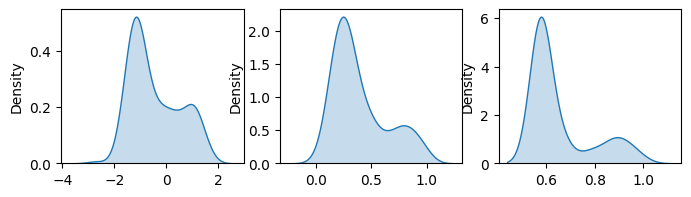

In [91]:
import seaborn as sns

fig, axs = plt.subplots(1,3, figsize=(8,2))
sns.kdeplot(t_stats, fill=True,ax=axs[0])
sns.kdeplot(p_values, fill=True,ax=axs[1])
sns.kdeplot(corrected_p_values, fill=True,ax=axs[2])

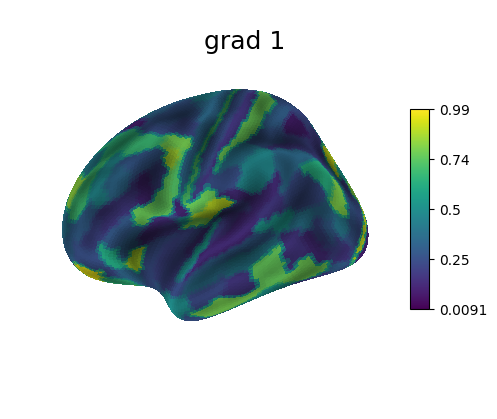

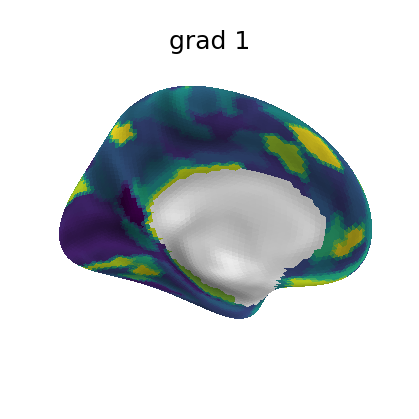

In [94]:
grad_map = map_to_labels(p_values,labeling_half, mask=mask_half, fill=np.nan)

nplt.plot_surf(surf_mesh= fsaverage.infl_left, surf_map= grad_map, # infl_right # pial_right
            view= 'lateral',cmap='viridis', colorbar=True, title=f'grad {n_grad}',
            bg_map=fsaverage.sulc_left, bg_on_data=True,darkness=0.7) 
plt.show()
nplt.plot_surf(surf_mesh= fsaverage.infl_left, surf_map= grad_map, # infl_right # pial_right
            view= 'medial',cmap='viridis', colorbar=False, title=f'grad {n_grad}',
            bg_map=fsaverage.sulc_left, bg_on_data=True,darkness=0.7) 
plt.show()